In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image
 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Image ID: 2000000283210
**************************************************
Categories: ['dog', 'chair']
Super Categories: ['animal', 'furniture']
**************************************************
S1: hello how are you today ?
S2: hi , my husband is old and adopted . i love coloring farms in books .
S1: ok that is random . i have never been an artist type
S2: great ! i live on a farm with a dog named trump who watches hockey .
S1: i do not care for dogs . i am waiting for retirement
S2: good luck with retirement . my dog trump is a german shepherd .
S1: thanks if only retirement will come faster . what do you do for a living ?
S2: actor . i adopted a dog and a husband in the same year .
S1: oh acting that sounds fun . sounds like you went through some big life events
S2: i did ! i got rid of my husband and kept the dog .
S1: well at least some good came out of it . hope everything is well for you
S2: it is ! we farm and watch hockey where i live . what about you ?
S1: i am not a big fa

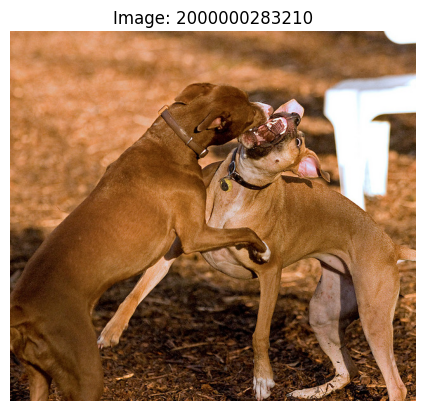

**************************************************
person CLIP feature similarity: 0.2144775390625
animal CLIP feature similarity: 0.2423095703125
vehicle CLIP feature similarity: 0.153564453125
outdoor CLIP feature similarity: 0.179931640625
accessory CLIP feature similarity: 0.2186279296875
sports CLIP feature similarity: 0.2115478515625
kitchen CLIP feature similarity: 0.211669921875
food CLIP feature similarity: 0.1580810546875
furniture CLIP feature similarity: 0.1759033203125
electronic CLIP feature similarity: 0.219970703125
appliance CLIP feature similarity: 0.202392578125
indoor CLIP feature similarity: 0.1947021484375


In [3]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "real")
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [4]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    16461
1      519
Name: count, dtype: int64

In [5]:
## Dialogue Processing
dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
df_table['dialogue_clip'] = list(dialogue_clip)

## Image Processing
image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
image_annotation.rename(columns={0:"image_clip"}, inplace=True)
df_table = df_table.merge(image_annotation, on='img_file', how='left')

In [6]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [8]:
df_table.columns

Index(['dialog', 'score', 'dialog_dataset', 'dialog_file', 'img_dataset',
       'img_file', 'set_source', 'image_id', 'image_idx', 'categories',
       'supercategories', 'OOD', 'dialogue_clip', 'image_clip',
       'encoded_label', 'person', 'animal', 'outdoor', 'accessory', 'sports',
       'kitchen', 'food', 'furniture', 'electronic', 'appliance', 'indoor'],
      dtype='object')

In [10]:
text = 'Category of food'
text_tokens = clip.tokenize([text]).to(device)  
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

In [11]:
text_features

tensor([[-1.3391e-01, -8.1909e-02,  3.0579e-02,  3.2135e-02,  8.8043e-03,
          1.0077e-01, -3.9087e-01, -1.2578e+00,  1.3367e-01,  1.3660e-01,
          7.5806e-02, -2.9877e-02, -1.7029e-01, -1.1298e-01, -1.4282e-01,
         -6.6223e-03,  4.7852e-01, -7.3547e-02, -3.9038e-01,  5.7678e-02,
         -2.5757e-01,  1.8347e-01, -2.0361e-01, -4.1229e-02,  1.4758e-01,
          5.7587e-02,  5.4138e-02, -1.6098e-02, -1.4565e-02,  2.5684e-01,
          9.0393e-02,  3.2501e-02, -7.7209e-02,  3.7659e-02, -2.6758e-01,
         -7.3730e-02,  6.5063e-02,  4.9667e-03,  3.2074e-02, -2.7319e-01,
         -2.0691e-01,  1.2238e-01,  4.1797e-01,  1.9055e-01, -5.8563e-02,
         -9.3567e-02,  1.6518e-03,  9.1675e-02,  1.3269e-01, -4.6234e-03,
         -1.3708e-01, -6.0254e-01, -2.4231e-02, -3.0078e-01,  1.2842e-01,
          8.8745e-02, -6.5308e-02,  1.3623e-01, -1.3269e-01,  3.0469e-01,
         -7.7698e-02, -4.6362e-01,  7.0435e-02, -2.1301e-01, -7.6843e-02,
         -3.6377e-01,  2.2583e-01,  2.

In [14]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")


def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text = 'Category ' + categories
        text_tokens = clip.tokenize([text]).to(device)  
        with torch.no_grad():
            text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += np.exp(cosine_sim_current)
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)

    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))

  0%|          | 0/16980 [00:00<?, ?it/s]

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Image Max Scores Distribution')
plt.xlabel('Image Max Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Dialogue Scores Distribution')
plt.xlabel('Dialogue Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Dialogue Max Scores Distribution')
plt.xlabel('Dialogue Max Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import importlib
importlib.reload(ev)

In [ ]:
ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.8)
ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.8)
ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.8)
ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.8)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MultiLabelNN(nn.Module):
    def __init__(self, input_size=512, output_size=11):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256) 
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, 64) 
        self.fc4 = nn.Linear(64, output_size)    
        self.relu = nn.ReLU()           
        self.sigmoid = nn.Sigmoid()    

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  
        return x


In [ ]:
df_ind = df_table[df_table['OOD'] == 0]
df_ind_train = df_ind.sample(frac=0.8, random_state=0)
df_ind_train = df_ind_train.loc[np.sort(df_ind_train.index)]
df_test = df_table.drop(df_ind_train.index)

In [ ]:
X_train = clip_features.loc[df_ind_train.index]
X_test = clip_features.loc[df_test.index]

In [ ]:
def evaluate(model, data_loader, loss_function):
    model.eval()  
    total_loss = 0
    total_accuracy = 0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            predictions = outputs > 0.5 
            total_accuracy += (predictions == labels.byte()).all(dim=1).float().mean().item()
            total_samples += 1

    average_loss = total_loss / total_samples
    average_accuracy = total_accuracy / total_samples

    return average_loss, average_accuracy

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 32
EPOCH = 20

X_train_tensor = torch.tensor(X_train.values).float() 
Y_train_tensor = torch.tensor(np.vstack(df_ind_train['encoded_label'].values)).float()

X_test_tensor = torch.tensor(X_test.values).float()
Y_test_tensor = torch.tensor(np.vstack(df_test['encoded_label'].values)).float()

dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

model = MultiLabelNN()
loss_function = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

for epoch in range(EPOCH):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

    average_loss, average_accuracy = evaluate(model, train_loader, loss_function)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_function)

    print(f'Epoch {epoch+1}, Train Loss: {average_loss:.4f}, Train Accuracy: {average_accuracy:.4f}')
    print(f'Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [ ]:
model.eval()  
with torch.no_grad():  
    for inputs, labels in test_loader:
        outputs = model(inputs)

In [ ]:
outputs_energy.shape

In [ ]:
outputs_energy = -np.log(1+outputs/(1-outputs))
outputs_energy_sum = outputs_energy.sum(axis=1)
df_test['energy_sum'] = outputs_energy_sum
df_test['energy_max'] = outputs_energy.min(axis=1).values.numpy()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_sum']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_sum']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_max']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_max']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [ ]:
ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum'].values, 0.8)

In [ ]:
ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max'].values, 0.8)